# Project Overview

E-commerce sites such as Shopee receive multiple product listings daily. To improve recommendations for both retailers and customers, there is a need to identify listings which represent identical products.

## Project Goal

This project aims to create a model that can determine which products are the same based on their product images. 

### Notebooks
1) Exloratory Data Analysis
2) Training and Modelling (You are Here!)

### Training and Modelling
Create models to predict which products are part of the same category in the dataset.

**Data and Analysis Preparations**
- Custom Train Test Split
- Importing images and creating image labels
- Create functions for data analysis


**Analysis**
1. Image Perceptual Hash
    - Identical Hash
    - Similar Hash
2. Identifying a pre-trained CNN model for further training
    - Preliminary Analysis with VGG16, ResNet50, InceptionV3, EfficientNetB0
    - Results of preliminary analysis
3. Transfer Learning and Fine Tuning with EfficientNetB0
    - Transfer Learning
    - Fine Tune EfficientNetB0 (1 layer)
    - Fine Tune EfficientNetB0 (1 Module)
    - Model Performance on Test Data
    - Consolidated Train and Test Results for EfficientNetB0
4. Alternative Metrics
    - Euclidean and Cosine Distance
5. Error Analysis
6. Conclusions and Recommendations


## Data and Analysis Preparations
This section will import and prepare the data required for analysis. Functions will be created for later use.

- Custom Train Test Split
- Importing images and creating image labels
- Create functions for data analysis

In [2]:
# import data

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import imagehash
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0


In [3]:
# Read in data

train = pd.read_csv('./data/train.csv')

In [4]:
# Create y_true columm
# y_true column contains all duplicated posting_id

y_true = train.groupby('label_group')['posting_id'].agg('unique').to_dict()

train['y_true'] = train['label_group'].map(y_true)
train.head(3)

,posting_id,image,image_phash,title,label_group,y_true
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"


### Custom train test split
We saw from EDA that there is a wide distribution of duplicates in the dataset (ie. some products only have ONE duplicate while others have up to 50). However products with many duplicates are few.

To account for this, a custom train_test_split will be performed to ensure that products with differing number of duplicates will be evenly split in the train and test set. At the same time, all classes in the train set, will not be in the test set.

In [5]:
# Get number of duplicates for each product

image_groups = train['label_group'].value_counts() 
image_groups = pd.DataFrame(image_groups)

image_groups = image_groups.reset_index()

In [6]:
# View the distribution of "number of duplicates"

image_groups.groupby('label_group')['label_group'].count()

label_group
2     6979
3     1779
4      862
5      468
6      282
7      154
8      118
9       91
10      48
11      38
12      39
13      28
14      19
15      19
16      13
17       9
18       5
19       5
20       6
21       6
22       6
23       4
24       2
25       2
26       1
27       1
30       1
31       2
32       3
33       3
34       3
35       4
36       1
37       1
41       1
45       1
46       2
49       1
51       7
Name: label_group, dtype: int64

In [7]:
# From 17 duplicates and above, the number of products 
# in each duplicate group range from 1 to 9
# We will group them as 17 to 51

image_groups['num_per_group'] = ["17 to 51" if x > 16 else str(x) for x in image_groups['label_group']]
image_groups.groupby('num_per_group')['label_group'].count()

num_per_group
10            48
11            38
12            39
13            28
14            19
15            19
16            13
17 to 51      77
2           6979
3           1779
4            862
5            468
6            282
7            154
8            118
9             91
Name: label_group, dtype: int64

In [8]:
# Train Test Split stratified by number of duplicates for each label_group

X = image_groups[['index']]       # label_groups of products
y = image_groups['num_per_group'] # number of duplicates for each label_group

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30,
    random_state=42,
    stratify=y)

In [9]:
# Create train and test dataframes

train_df = train.loc[train['label_group'].isin(X_train['index']),:].copy()
test_df = train.loc[train['label_group'].isin(X_test['index']),:].copy()

In [10]:
# Check if train_test_split was successful

train_df_group = train_df['label_group'].value_counts() 
train_df_group = pd.DataFrame(train_df_group)
train_df_group = train_df_group.reset_index()

train_df_group.groupby('label_group')['label_group'].count()

label_group
2     4885
3     1245
4      603
5      327
6      197
7      108
8       83
9       64
10      34
11      27
12      27
13      20
14      13
15      13
16       9
17       6
18       4
19       2
20       3
21       4
22       5
23       2
24       2
25       2
27       1
30       1
31       1
32       3
33       1
34       3
35       3
36       1
37       1
45       1
46       2
49       1
51       5
Name: label_group, dtype: int64

In [41]:
# Create a subset of data to experiment

sub_train = train_df.loc[train_df['label_group'].isin(train_df['label_group'][:100]),:].copy()


### Read in images and create image labels

In [11]:
# Function to read in all Images into an array

train_img_path = './data/train_images/'

def read_images(image_list):
    images = []
    # Loop over all IDs and read each image in one by one
    with tqdm(total=len(image_list)) as pbar:
      for image_id in image_list:
          images.append(np.array(image.load_img(train_img_path + f"{image_id}", target_size=(224, 224))))
          pbar.update(1)
      images = np.asarray(images)
      print(f"Image array shape is {images.shape}")
      return images

In [12]:
# Read in images for different sets

X_train = read_images(train_df['image'])
X_test = read_images(test_df['image'])
#sub_xtrain = read_images(sub_train['image'])
#X_train = sub_xtrain


100%|██████████| 24020/24020 [03:40<00:00, 109.16it/s]


Image array shape is (24020, 224, 224, 3)


100%|██████████| 10230/10230 [01:48<00:00, 94.25it/s] 

Image array shape is (10230, 224, 224, 3)


In [11]:
# Create label groups for data

def create_labels(df):
    # Group data by label_groups
    groups = df['label_group'].value_counts() 
    groups = pd.DataFrame(groups)

    # Create new groups labels 
    groups['new_group'] = list(range(groups.shape[0]))
    labels = groups[['new_group']].to_dict()
    df['new_group'] = df['label_group'].map(labels['new_group'])

#    y_array = utils.to_categorical(np.array(df['new_group']))
    print(f"Number of unique classes in dataset is {len(set(df['new_group']))}")
    return df['new_group']

In [12]:
# Create label groups for data

y_train = create_labels(train_df)
y_test = create_labels(test_df)
#sub_ytrain = create_labels(sub_train)
#y_train = sub_ytrain

Number of unique classes in dataset is 7709
Number of unique classes in dataset is 3305


### Create functions for analysis
1. Compute F1 score
2. Extract features from CNN models
3. Get distances using Nearest Neighbor
4. Find the best threshold distance with best Mean F1 Score
5. Create dataframe for error analysis


In [13]:
# Compute F1 score
# F1 score :
# (2 x Precision x Recall)/(Precision + Recall)

# Precision: 
# TP/ (TP + FP)
# len(overlap between true and pred)/(len(pred))

# Recall: 
# TP/ (TP + FN)
# len(overlap between true and pred)/(len(true))

def get_f1(col):
    def f1_for(row):
        prec = len(np.intersect1d(row['y_true'], row[col]))/len(row[col])
        reca = len(np.intersect1d(row['y_true'], row[col]))/len(row['y_true'])
        fl = (2*prec*reca)/(prec+reca)
        return fl
    return f1_for

In [14]:
# Extract features from CNN models

train_img_path = './data/train_images/'

def feature_extract(pre_model, df, im_size, embed_size):
    embeddings=np.zeros((df.shape[0], embed_size))
    with tqdm(total=df.shape[0]) as pbar:
        for idx,im in enumerate(df['image']):
            img = image.load_img(train_img_path+im, target_size=(im_size, im_size))
            x = image.img_to_array(img)
            x = x.reshape(1, im_size, im_size, 3)
            x = preprocess_input(x)
            pred = pre_model.predict(x)
            embeddings[idx] = pred
            pbar.update(1)
    return embeddings


In [15]:
# Get distances using Nearest Neighbor (Euclidean Distance)

def NN_model(embeddings):
    print(embeddings.shape)
    model_nn =  NearestNeighbors(n_neighbors=50)
    model_nn.fit(embeddings)
    distances, indices = model_nn.kneighbors(embeddings)

    return distances, indices

In [16]:
# Get distances using Nearest Neighbor (Cosine Distance)

def NN_model_cos(embeddings):
    print(embeddings.shape)
    model_nn =  NearestNeighbors(n_neighbors=50, metric = 'cosine')
    model_nn.fit(embeddings)
    distances, indices = model_nn.kneighbors(embeddings)

    return distances, indices

In [17]:
# Find the best threshold distance with best Mean F1 Score

def best_predictions(df, thresholds, distances, indices, model_name, num_epochs):

    df_iter = df[['y_true', 'posting_id']].copy()
    best_threshold = {'threshold_b': 0, 'score': 0}

    with tqdm(total=len(thresholds)) as pbar:
        for threshold in thresholds:
            preds = []
            for k in range(df_iter.shape[0]):
                IDX = np.where(distances[k,]<threshold)[0]
                IDS = indices[k,IDX]
                o = df_iter.iloc[IDS]['posting_id'].values
                preds.append(o)

            df_iter['pred_matches'] = preds
            df_iter['f1'] = df_iter.apply(get_f1('pred_matches'),axis=1)
            mean_f1 = df_iter['f1'].mean()
            if mean_f1 > best_threshold['score']:
                best_threshold['threshold_b'] = threshold
                best_threshold['score'] = mean_f1
            pbar.update(1)
        if len(best_threshold) == 1:
            print(f"Mean f1 score with threshold {best_threshold['threshold_b']} is {best_threshold['score']}")
        else:
            print(f"Best mean f1 score for threshold {best_threshold['threshold_b']} is {best_threshold['score']}")
    
    results = {"Model": model_name,
               "Epochs": num_epochs,
               "best_threshold": best_threshold['threshold_b'],
               "Mean_f1": best_threshold['score']}

    return results

In [18]:
# Get predicted similar products using best threshold and Cosine Distance
# Include extra variables to data frame for errer analysis

def prediction_results(df_iter, df_name, threshold, distances, indices):
    preds = []
    for k in range(df_iter.shape[0]):
        IDX = np.where(distances[k,]<threshold)[0]
        IDS = indices[k,IDX]
        o = df_iter.iloc[IDS]['posting_id'].values
        preds.append(o)


    df_iter['y_pred'] = preds
    df_iter['f1'] = df_iter.apply(get_f1('y_pred'),axis=1)
    mean_f1 = df_iter['f1'].mean()

    # map mean f1 score for each label_group to label member
    f1_label_mean = df_iter.groupby('label_group')['f1'].mean().to_dict()
    df_iter['f1_label_mean'] = df_iter['label_group'].map(f1_label_mean)

    # y_true length and y_pred length
    df_iter['y_true_len'] = [len(x) for x in df_iter['y_true']]
    df_iter['y_pred_len'] = [len(x) for x in df_iter['y_pred']]

    return f"Predictions added for {df_name}. Mean f1 score for model is {mean_f1}"

## Analysis using Image Perceptual Hash
The perceptual hash(phash) of an image is generated using a mathematical algorithm which analyzes the image's content and represents it using a 64-bit number fingerprint. Images which are very similar will have the same phash.

phash can also be subtracted from other phash to obtain an integer difference. Small phash differences indicate similar images while large phash differences indicate dissimilar images.

1. Identical Image hash
2. Similar Image Hash


### Analysis using Identical phash

In [23]:
# Create variable with posting ids of identical image_phash

# train data
y_phash_id = train_df.groupby('image_phash')['posting_id'].agg('unique').to_dict()
train_df['y_phash_id'] = train_df['image_phash'].map(y_phash_id)

# test data

y_phash_id = test_df.groupby('image_phash')['posting_id'].agg('unique').to_dict()
test_df['y_phash_id'] = test_df['image_phash'].map(y_phash_id)

In [48]:
# Score if we use provided phash to identify images with IDENTICAL phash

train_df['phash_id_f1'] = train_df.apply(get_f1('y_phash_id'),axis=1)
print('Mean F1 score for identical phash in train =', train_df['phash_id_f1'].mean())

test_df['phash_id_f1'] = test_df.apply(get_f1('y_phash_id'),axis=1)
print('Mean F1 score for identical phash in test =', test_df['phash_id_f1'].mean())


Mean F1 score for identical phash in train = 0.55149979747809
Mean F1 score for identical phash in test = 0.5594498051469015


### Analysis using Similar phash

**Train Data**

In [255]:
# Train Data
# Convert provided phash_hex to phash 64-bit object
# Gets inter image phash distances

train_phash = train_df['image_phash'].apply(lambda x: imagehash.hex_to_hash(x))
train_phash = train_phash.reset_index(drop=True)

all_diff = []

with tqdm(total=len(train_phash)) as pbar:
    for idx, hash in enumerate(train_phash):
        dist_list = []
        for idx_e, h_e in enumerate(train_phash):
            each_diff = hash - train_phash[idx_e]
            dist_list.append(each_diff)
        all_diff.append(dist_list)
        pbar.update(1)


100%|██████████| 24020/24020 [1:27:25<00:00,  4.58it/s]  


In [261]:
# Train Data
# Use Hash differences to find similar products
# Function to find the best threshold

distances = np.array(all_diff)
thresholds = list(np.arange(5, 13, 1))
df_iter = train_df[['y_true', 'posting_id']].copy()
best_threshold = {'threshold_b': 0, 'score': 0}

with tqdm(total=len(thresholds), position=0) as pbar:
    for threshold in thresholds:
        preds = []
        for k in range(df_iter.shape[0]):
            IDX = np.where(distances[k,]<threshold)
            o = df_iter.iloc[IDX]['posting_id'].values
            preds.append(o)

        df_iter['pred_matches'] = preds
        df_iter['f1'] = df_iter.apply(get_f1('pred_matches'),axis=1)
        mean_f1 = df_iter['f1'].mean()
        if mean_f1 > best_threshold['score']:
            best_threshold['threshold_b'] = threshold
            best_threshold['score'] = mean_f1
        pbar.update(1)
    print(f"Our best f1 score for threshold {best_threshold['threshold_b']} is {best_threshold['score']}")


100%|██████████| 8/8 [01:12<00:00,  9.07s/it]

Our best f1 score for threshold 9 is 0.5961665304146646


**Test Data**

In [263]:
# Test Data
# Convert provided phash_hex to phash 64-bit object
# Gets inter image phash distances

test_phash = test_df['image_phash'].apply(lambda x: imagehash.hex_to_hash(x))
test_phash = test_phash.reset_index(drop=True)

test_diff = []

with tqdm(total=len(test_phash)) as pbar:
    for idx, hash in enumerate(test_phash):
        dist_list = []
        for idx_e, h_e in enumerate(test_phash):
            each_diff = hash - test_phash[idx_e]
            dist_list.append(each_diff)
        test_diff.append(dist_list)
        pbar.update(1)

100%|██████████| 10230/10230 [16:24<00:00, 10.39it/s]


In [ ]:
# Test Data
# Use Hash differences to find similar products
# Function to find the best threshold

test_phash = test_df['image_phash'].apply(lambda x: imagehash.hex_to_hash(x))
test_phash = test_phash.reset_index(drop=True)

test_diff = []

with tqdm(total=len(test_phash)) as pbar:
    for idx, hash in enumerate(test_phash):
        dist_list = []
        for idx_e, h_e in enumerate(test_phash):
            each_diff = hash - test_phash[idx_e]
            dist_list.append(each_diff)
        test_diff.append(dist_list)
        pbar.update(1)

In [272]:
distances = np.array(test_diff)
threshold = 9
test_iter = test_df[['y_true', 'posting_id']].copy()
preds = []

   
for k in range(test_iter.shape[0]):
    IDX = np.where(distances[k,]<threshold)
    o = test_iter.iloc[IDX]['posting_id'].values
    preds.append(o)

test_iter['pred_matches'] = preds
test_iter['f1'] = test_iter.apply(get_f1('pred_matches'),axis=1)
mean_f1 = test_iter['f1'].mean()


print(f"f1 score with threshold {threshold} is {mean_f1}")

f1 score with threshold 9 is 0.6130351779026791


## Identifying a pre-trained CNN model for further training
Multiple pre-trained CNN models are available. We will first test the predictive ability of some of these models using a fraction of the dataset, and pick the best performing one to further develop.

### Preliminary Analysis with pre-trained CNN
1. VGG16
2. ResNet50
3. InceptionV3
4. EfficientNetB0

**VGG16**

In [234]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", pooling="avg",
                     include_top=False, input_shape=(224, 224, 3))

In [235]:
embeddings = feature_extract(base_model, sub_train, 224, 512)

print(embeddings.shape)

100%|██████████| 437/437 [02:45<00:00,  2.65it/s]

(437, 512)


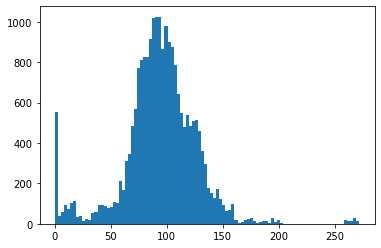

In [236]:
# Find Nearest Neighbor
distances, indices = NN_model(embeddings)

new_shape = distances.shape[0]*50
plt.hist((distances.reshape(new_shape)), bins=100);

In [237]:
best_predictions(sub_train, list(np.arange(1, 75, 1)), distances, indices)

100%|██████████| 74/74 [00:14<00:00,  5.16it/s]

Our best f1 score for threshold 64 is 0.5875367811492818


**ResNet50**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

## Loading ResNet50 model
base_model = ResNet50(weights="imagenet", pooling="avg",
                     include_top=False, input_shape=(224, 224, 3))


In [239]:
embeddings = feature_extract(base_model, sub_train, 224, 2048)

print(embeddings.shape)

100%|██████████| 437/437 [01:53<00:00,  3.84it/s]

(437, 2048)


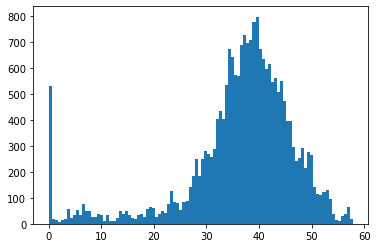

In [240]:
# Find Nearest Neighbor
distances, indices = NN_model(embeddings)

new_shape = distances.shape[0]*50
plt.hist((distances.reshape(new_shape)), bins=100);

In [241]:
best_predictions(sub_train, list(np.arange(1, 40, 0.5)), distances, indices)

100%|██████████| 78/78 [00:14<00:00,  5.23it/s]

Our best f1 score for threshold 29.0 is 0.6284445755717432


**InceptionV3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model = InceptionV3(weights = 'imagenet', pooling="avg",
include_top = False, input_shape = (299, 299, 3))


In [243]:
embeddings = feature_extract(base_model, sub_train, 299, 2048)

print(embeddings.shape)

100%|██████████| 437/437 [02:33<00:00,  2.84it/s]

(437, 2048)


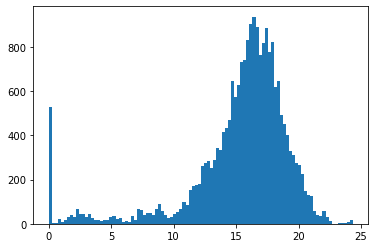

In [200]:
# Find Nearest Neighbor
distances, indices = NN_model(embeddings)


new_shape = distances.shape[0]*50
plt.hist((distances.reshape(new_shape)), bins=100);

In [246]:
best_predictions(sub_train, list(np.arange(2, 20, 0.1)), distances, indices)

100%|██████████| 180/180 [00:30<00:00,  5.83it/s]

Our best f1 score for threshold 19.900000000000016 is 0.5430053623084863


**EfficientNetB0**

In [25]:
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB0

## Loading EfficientNetB7 model
base_model = EfficientNetB0(weights="imagenet", pooling="avg",
                     include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False ## Not trainable weights

In [26]:
embeddings = feature_extract(base_model, sub_train, 224, 1280)

print(embeddings.shape)

100%|██████████| 437/437 [00:53<00:00,  8.17it/s]

(437, 1280)


(437, 1280)


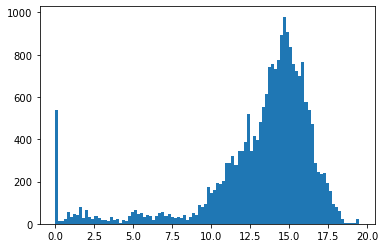

In [27]:
# Find Nearest Neighbor
distances, indices = NN_model(embeddings)


new_shape = distances.shape[0]*50
plt.hist((distances.reshape(new_shape)), bins=100);

In [29]:
best_predictions(sub_train, list(np.arange(1, 15, 0.25)), distances, indices)

100%|██████████| 56/56 [00:07<00:00,  7.87it/s]

Our best f1 score for threshold 11.75 is 0.6479985362076162


### Results of Transfer Learning for a Subset of Train data

| **CNN Model**  | **Mean F1** |
|----------------|-------------|
| VGG16          | 0.588       |
| ResNet50       | 0.628       |
| InceptionV3    | 0.543       |
| EfficientNetB0 | 0.648       |

Sample of 437 data points used.


Based on the results of the analysis using a subset of train data, EfficientNetB0 outperforms the other models based on Mean F1 score.

## Transfer Learning and Fine Tuning
Using EfficientNetB0 as the base model, fine tuning will be performed so that the higher-order feature representations in the base model will be more relevant for our task. Varying number of layers and training epochs will be attempted.

1. Transfer Learning with EfficientB0
2. Fine Tune EfficientNetB0 (1 Layer)
3. Fine Tune EfficientNetB0 (1 module, several layers)


### Transfer Learning with EfficientB0

**TRAINING DATASET**

In [276]:
# Extract Embeddings

from tensorflow.keras.applications.efficientnet import preprocess_input

model = EfficientNetB0(weights='imagenet',include_top=False, pooling='avg', input_shape=(224, 224, 3))

embeddings = feature_extract(model, train_df, 224, 1280)


100%|██████████| 24020/24020 [1:05:06<00:00,  6.15it/s]


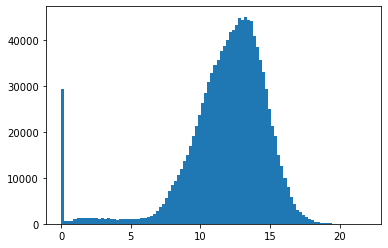

In [278]:
# Find Nearest Neighbor
distances, indices = NN_model(embeddings)

new_shape = distances.shape[0]*50
plt.hist((distances.reshape(new_shape)), bins=100); # View the thresholds that we will need to search over

# distances is an array of sample_size x 50 with the DISTANCES to 50 nearest neighbors
# indices is an array of sample_size x 50 with the INDICES to 50 nearest

In [283]:
# Fine best threshold and Mean f1 score

best_predictions(train_df, list(np.arange(1, 15, 0.25)), distances, indices)

100%|██████████| 56/56 [06:31<00:00,  7.00s/it]

Our best f1 score for threshold 7.5 is 0.6493706951509285


**TEST DATASET**

In [285]:
# Extract Embeddings

#from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB0

model = EfficientNetB0(weights='imagenet',include_top=False, pooling='avg', input_shape=(224, 224, 3))

embeddings = feature_extract(model, test_df, 224, 1280)

  # takes 2-3mins for 480*480 

100%|██████████| 10230/10230 [33:34<00:00,  5.08it/s] 


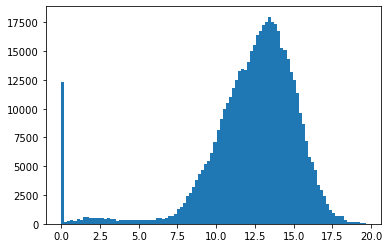

In [287]:
# Find Nearest Neighbor
distances, indices = NN_model(embeddings)

new_shape = distances.shape[0]*50
plt.hist((distances.reshape(new_shape)), bins=100);

In [289]:
# Get Predictions

best_predictions(test_df, [7.5], distances, indices)

100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

Our best f1 score for threshold 7.5 is 0.6714361216369747


| **Model**        | **Best Threshold** | **Train Set** (Mean F1) | **Train Set** (Mean F1) |
|------------------|--------------------|-------------------------|-------------------------|
| phash similarity | 9                  | 0.596                   | 0.613                   |
| EnetB0_TL        | 7.5                | 0.649                   | 0.671                   |

The EfficientNetB0 Transfer Learning model has a better score than the phash similarity model. Subsequent Analysis will focus on fine tuning the model 

### Fine Tune EfficientNetB0 (1 Layer)
- Train over 3 epochs
- Train over 6 epochs

#### Fine Tune EfficientNetB0 (1 Layer)
**Training Epochs 1-3**

In [19]:
def create_efn0_model():

    efn0 = EfficientNetB0(
    weights="imagenet",         # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,          # Do not include the ImageNet classifier at the top.
)  
    efn0.trainable = False
    n_classes = len(set(train_df['new_group']))

    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(efn0.output)
    prediction = Dense(n_classes, activation='softmax')(x)

    f_model = Model(inputs = efn0.input, outputs = prediction)

    # Compile model
    f_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

    return f_model

In [19]:
model_1a = create_efn0_model()

In [20]:
# Unfreeze 1 conv layer

for layer in model_1a.layers[-5:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [21]:
# Compile model

model_1a.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [22]:
# Create checkpoints to save

checkpoint_path = "./training/model_1a_3.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,                                           
    monitor='val_acuracy'
    )

In [23]:
# Train model

history_1a = model_1a.fit(
        X_train,
        y_train,
        batch_size=128,           
        epochs=3,               # Epochs 1 to 3
        callbacks=[checkpoint],
)

Epoch 1/3
188/188 [==============================] - 1101s 6s/step - loss: 7.4349 - sparse_categorical_accuracy: 0.1740
Epoch 2/3
188/188 [==============================] - 1151s 6s/step - loss: 2.0034 - sparse_categorical_accuracy: 0.6487
Epoch 3/3
188/188 [==============================] - 1049s 6s/step - loss: 0.3027 - sparse_categorical_accuracy: 0.9385


In [24]:
# Create model without the prediction layer

model_1a_pen = Model(inputs = model_1a.input, outputs = model_1a.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1a_pen, train_df, 224, 1280)

100%|██████████| 24020/24020 [40:21<00:00,  9.92it/s]


In [25]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(train_df, list(np.arange(8, 30, 0.25)), distances, indices, "Model_1a", 3)

(24020, 1280)


100%|██████████| 88/88 [07:50<00:00,  5.35s/it]


Best mean f1 score for threshold 16.5 is 0.6637781460380308


In [27]:
# Delete temporary variables to free memory
del embeddings
del distances
del indices

#### Fine Tune EfficientNetB0 (1 Layer)
**Training Epochs 4-6**

In [28]:
# Create model and load weights

model_1a = None
model_1a = create_efn0_model()
model_1a.load_weights("./training/model_1a_3.ckpt")

In [29]:
# Unfreeze layers

for layer in model_1a.layers[-5:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [30]:
# Compile model

model_1a.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower learning rate to reduce overfitting
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [31]:
# Create checkpoints to save

checkpoint_path = "./training/model_1a_6.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,                                           
    monitor='val_acuracy'
    )

In [32]:
# Train model

history_1a = model_1a.fit(
        X_train,
        y_train,
        batch_size=128,           
        epochs=3,               # Epochs 6 to 8
        callbacks=[checkpoint],
)

Epoch 1/3
188/188 [==============================] - 974s 5s/step - loss: 0.1087 - sparse_categorical_accuracy: 0.9785
Epoch 2/3
188/188 [==============================] - 974s 5s/step - loss: 0.0554 - sparse_categorical_accuracy: 0.9879
Epoch 3/3
188/188 [==============================] - 975s 5s/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9911


In [33]:
# Create model without the prediction layer

model_1a_pen = Model(inputs = model_1a.input, outputs = model_1a.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1a_pen, train_df, 224, 1280)

100%|██████████| 24020/24020 [40:30<00:00,  9.88it/s] 


In [34]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(train_df, list(np.arange(8, 30, 0.25)), distances, indices,  "Model_1a", 6)

(24020, 1280)


100%|██████████| 88/88 [07:40<00:00,  5.23s/it]


Best mean f1 score for threshold 18.25 is 0.6635393803098024


In [36]:
# Delete temporary variables to free memory
del embeddings
del distances
del indices

### Fine Tune EfficientNetB0 (1 Module)
- Train over 3 epochs
- Train over 6 epochs
- Train over 9 epochs

#### Fine Tune EfficientNetB0 (1 Module)
**Training Epochs 1-3**

In [37]:
# Create model
model_1b = create_efn0_model()

In [38]:
# Unfreeze layers

for layer in model_1b.layers[221:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [39]:
# Check unfreezing

for layer in model_1b.layers:
  if layer.trainable:
    print(layer.trainable, layer.name)

True block7a_expand_conv
True block7a_expand_activation
True block7a_dwconv
True block7a_activation
True block7a_se_squeeze
True block7a_se_reshape
True block7a_se_reduce
True block7a_se_expand
True block7a_se_excite
True block7a_project_conv
True top_conv
True top_activation
True avg_pool
True dense_2


In [40]:
# Compile model

model_1b.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [41]:
# Create checkpoints to save

checkpoint_path = "./training/model_1b_3.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,                                           
    monitor='val_acuracy'
    )

In [42]:
# Train model

history_1b = model_1b.fit(
        X_train,
        y_train,
        batch_size=128,           
        epochs=3,               # Epochs 1 to 3
        callbacks=[checkpoint],
)

Epoch 1/3
188/188 [==============================] - 1035s 6s/step - loss: 7.2310 - sparse_categorical_accuracy: 0.1699
Epoch 2/3
188/188 [==============================] - 1043s 6s/step - loss: 1.8571 - sparse_categorical_accuracy: 0.6423
Epoch 3/3
188/188 [==============================] - 1053s 6s/step - loss: 0.2714 - sparse_categorical_accuracy: 0.9400


In [20]:
# Create model without the prediction layer

model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_3.ckpt")


model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1b_pen, train_df, 224, 1280)

100%|██████████| 24020/24020 [49:54<00:00,  8.02it/s] 


In [21]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(train_df, list(np.arange(8, 50, 0.25)), distances, indices, "Model_1b", 3)

(24020, 1280)


100%|██████████| 168/168 [17:47<00:00,  6.35s/it]


Best mean f1 score for threshold 27.75 is 0.6808958382395462


In [ ]:
# Delete temporary variables to free memory
del embeddings
del distances
del indices

#### Fine Tune EfficientNetB0 (1 Module)
**Training Epochs 4-6**

In [47]:
# Create model and load weights

model_1b = None
model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_3.ckpt")

In [48]:
# Unfreeze layers

for layer in model_1b.layers[221:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [49]:
# Compile model

model_1b.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower learning rate to reduce overfitting
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [50]:
# Create checkpoints to save

checkpoint_path = "./training/model_1b_6.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,                                           
    monitor='val_acuracy'
    )

In [51]:
# Train model

history_1b = model_1b.fit(
        X_train,
        y_train,
        batch_size=128,           
        epochs=3,               # Epochs 6 to 8
        callbacks=[checkpoint],
)

Epoch 1/3
188/188 [==============================] - 1042s 6s/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9794
Epoch 2/3
188/188 [==============================] - 1044s 6s/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9884
Epoch 3/3
188/188 [==============================] - 1045s 6s/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9920


In [22]:
# Create model without the prediction layer

model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_6.ckpt")


model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1b_pen, train_df, 224, 1280)

100%|██████████| 24020/24020 [46:12<00:00,  8.66it/s]


In [23]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(train_df, list(np.arange(8, 50, 0.25)), distances, indices, "Model_1b", 6)

(24020, 1280)


100%|██████████| 168/168 [23:15<00:00,  8.30s/it]


Best mean f1 score for threshold 32.25 is 0.6863004930662994


In [ ]:
# Delete temporary variables to free memory
del embeddings
del distances
del indices

#### Fine Tune EfficientNetB0 (1 Module)
**Training Epochs 7-9**

In [20]:
# Create model and load weights

model_1b = None
model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_6.ckpt")

In [21]:
# Unfreeze layers

for layer in model_1b.layers[221:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
# Compile model

model_1b.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower learning rate to reduce overfitting
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [22]:
# Create checkpoints to save

checkpoint_path = "./training/model_1b_9.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,                                           
    monitor='val_acuracy'
    )

In [23]:
# Train model

history_1b = model_1b.fit(
        X_train,
        y_train,
        batch_size=128,           
        epochs=3,               # Epochs 6 to 8
        callbacks=[checkpoint],
)

Epoch 1/3
188/188 [==============================] - 1132s 6s/step - loss: 0.0179 - sparse_categorical_accuracy: 0.9937
Epoch 2/3
188/188 [==============================] - 1403s 7s/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9948
Epoch 3/3
188/188 [==============================] - 1310s 7s/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9947


In [24]:
# Create model without the prediction layer

model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1b_pen, train_df, 224, 1280)

100%|██████████| 24020/24020 [1:00:02<00:00,  6.67it/s]


In [25]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(train_df, list(np.arange(15, 45, 0.25)), distances, indices, "Model_1b", 9)

(24020, 1280)


100%|██████████| 120/120 [19:33<00:00,  9.78s/it]


Best mean f1 score for threshold 32.25 is 0.6863004930662994


In [ ]:
# Delete temporary variables to free memory
del embeddings
del distances
del indices

In [26]:
# Get distances using Nearest Neighbor

def NN_model_cos(embeddings):
    print(embeddings.shape)
    model_nn =  NearestNeighbors(n_neighbors=50, metric = 'cosine')
    model_nn.fit(embeddings)
    distances, indices = model_nn.kneighbors(embeddings)

    return distances, indices

(24020, 1280)


(array([3.6574e+04, 4.6760e+03, 2.8320e+03, 2.4360e+03, 1.8840e+03,
        1.5080e+03, 1.3000e+03, 1.2620e+03, 1.1740e+03, 1.1400e+03,
        1.0420e+03, 1.0720e+03, 1.0060e+03, 1.0200e+03, 1.1160e+03,
        1.1440e+03, 1.2100e+03, 1.1120e+03, 1.1300e+03, 1.1720e+03,
        1.2620e+03, 1.4080e+03, 1.4780e+03, 1.4420e+03, 1.5100e+03,
        1.7340e+03, 1.8640e+03, 2.0580e+03, 2.1740e+03, 2.4080e+03,
        2.2800e+03, 2.5760e+03, 3.0440e+03, 3.2460e+03, 3.6780e+03,
        4.2040e+03, 4.4800e+03, 5.1280e+03, 6.0570e+03, 6.9700e+03,
        7.4660e+03, 8.4770e+03, 1.0207e+04, 1.1446e+04, 1.3152e+04,
        1.5171e+04, 1.6790e+04, 1.9024e+04, 2.1197e+04, 2.3627e+04,
        2.5515e+04, 2.7852e+04, 3.1138e+04, 3.4219e+04, 3.6672e+04,
        4.0086e+04, 4.3106e+04, 4.5584e+04, 4.7450e+04, 4.8348e+04,
        4.9851e+04, 5.0539e+04, 5.0672e+04, 4.9709e+04, 4.7642e+04,
        4.5450e+04, 4.2748e+04, 3.8721e+04, 3.4300e+04, 2.9386e+04,
        2.4517e+04, 2.0150e+04, 1.6608e+04, 1.30

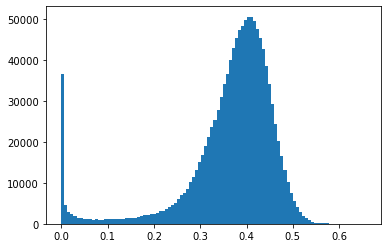

In [27]:
# Find Nearest Neighbor

distances_cos, indices_cos = NN_model_cos(embeddings)

new_shape = distances_cos.shape[0]*50
plt.hist(distances_cos.reshape(new_shape), bins=100)

In [28]:
best_predictions(train_df, list(np.arange(0.001, 0.4, 0.005)), distances_cos, indices_cos, "Model_1b", 9)

100%|██████████| 100/100 [13:14<00:00,  7.95s/it]

Best mean f1 score for threshold 0.226 is 0.7159008091419773


### Model Performance on Test Data

**EfficientNetB0 (Fine Tune 1 Layer)**
- Epochs 1-3
- Epochs 4-6

**EfficientNetB0 (Fine Tune 1 Module)**
- Epochs 1-3
- Epochs 4-6
- Epochs 7-9

#### EfficientNetB0 (Fine Tune 1 Layer)
- Results Generation

In [26]:
model_1a = create_efn0_model()
model_1a.load_weights("./training/model_1a_3.ckpt")

In [34]:
# Create model without the prediction layer

model_1a_pen = Model(inputs = model_1a.input, outputs = model_1a.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1a_pen, test_df, 224, 1280)

100%|██████████| 10230/10230 [21:20<00:00,  7.99it/s]


In [35]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(test_df, [16.5], distances, indices, "Model_1a", 3)

(10230, 1280)


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

Best mean f1 score for threshold 16.5 is 0.6858064102060932


In [ ]:
del embeddings
del distances
del indices

In [27]:
model_1a = create_efn0_model()
model_1a.load_weights("./training/model_1a_6.ckpt")

In [28]:
# Create model without the prediction layer

model_1a_pen = Model(inputs = model_1a.input, outputs = model_1a.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1a_pen, test_df, 224, 1280)

100%|██████████| 10230/10230 [17:54<00:00,  9.52it/s]


In [29]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(test_df, [18.25], distances, indices, "Model_1a", 6)

(10230, 1280)


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

Best mean f1 score for threshold 18.25 is 0.6881831951531504


In [42]:
del embeddings, distances, indices

#### EfficientNetB0 (Fine Tune 1 Module)
- Results Generation

In [30]:
model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_3.ckpt")

In [31]:
# Create model without the prediction layer

model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1b_pen, test_df, 224, 1280)

100%|██████████| 10230/10230 [17:48<00:00,  9.58it/s]


In [32]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(test_df, [27.75], distances, indices, "Model_1b", 3)

(10230, 1280)


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

Best mean f1 score for threshold 27.75 is 0.6962924488118047


In [47]:
del embeddings
del distances
del indices

In [48]:
model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_6.ckpt")

In [24]:
# Create model without the prediction layer

model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1b_pen, test_df, 224, 1280)

100%|██████████| 10230/10230 [18:54<00:00,  9.01it/s]


In [25]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(test_df, [32.25], distances, indices, "Model_1b", 6)

(10230, 1280)


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

Best mean f1 score for threshold 32.25 is 0.701111292753187


In [ ]:
model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_6.ckpt")

In [ ]:
# Create model without the prediction layer

model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings = feature_extract(model_1b_pen, test_df, 224, 1280)

100%|██████████| 10230/10230 [18:54<00:00,  9.01it/s]


In [ ]:
# Find Nearest Neighbor

distances, indices = NN_model(embeddings)

best_predictions(test_df, [32.25], distances, indices, "Model_1b", 6)

(10230, 1280)


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

Best mean f1 score for threshold 32.25 is 0.701111292753187


### Consolidated Results after Fine Tuning

| **Model**                                     | **Epochs** | **Best Threshold** | **Train Set**<br/> (Mean F1) | **Train Set**<br/> (Mean F1) |
|-----------------------------------------------|------------|--------------------|------------------------------|------------------------------|
| phash similarity                              | -          | 9                  | 0.596                        | 0.613                        |
| EnetB0_TL                                     | -          | 7.5                | 0.649                        | 0.671                        |
| EnetB0_FT (1 layer)                           | 3          | 16.5               | 0.664                        | 0.686                        |
| EnetB0_FT (1 layer)                           | 6          | 18.25              | 0.664                        | 0.688                        |
| EnetB0_FT (1 Module)                          | 3          | 27.75              | 0.681                        | 0.696                        |
| **EnetB0_FT (1 Module)**                      | **6**      | **32.25**          | **0.686**                    | **0.701**                    |
| EnetB0_FT (1 Module)                          | 9          | 32.25              | 0.686                        | 0.701                        |

In general, fine tuning improved the performance of the models. Modules with 1 module unfrozen had a better performance than models with only 1 layer unfrozen. Performance of the models did not improve much after training for 3 Epochs. For EnetB0_FT (1 module), we trained up to 9 epochs as we noticed minor improvements in score from epoch 3 to epoch 6.

The models did not show evidence of overfitting, as the scores on the test set did not drop after training. This is expected as the images in the train data is extremely diverse with 7,000 classes.

EnetB0_FT (1 Module) with 6 epochs was chosen to be further worked on.

### Alternative Metrics
The models so far have have used the Euclidean distance metric. In this section, the cosine distance will be used on EnetB0_FT (1 Module) 6 epochs.

**Testing with Cosine Distance (train)**

In [19]:
# Get distances using Nearest Neighbor

def NN_model_cos(embeddings):
    print(embeddings.shape)
    model_nn =  NearestNeighbors(n_neighbors=50, metric = 'cosine')
    model_nn.fit(embeddings)
    distances, indices = model_nn.kneighbors(embeddings)

    return distances, indices

In [21]:
model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_6.ckpt")

In [22]:
# Create model without the prediction layer

model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings_train = feature_extract(model_1b_pen, train_df, 224, 1280)

100%|██████████| 24020/24020 [47:29<00:00,  8.43it/s] 


In [23]:
# Find Nearest Neighbor

distances_cos_train, indices_cos_train = NN_model_cos(embeddings_train)

#new_shape = distances_cos.shape[0]*50
#plt.hist(distances_cos.reshape(new_shape), bins=100)

(24020, 1280)


In [32]:
m1b_9e_results_cos = best_predictions(train_df, [0.225],
                                  distances_cos_train, indices_cos_train, "Model_1b", 9)

**Testing with Cosine Distance (test)**

In [ ]:
model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_6.ckpt")

In [24]:
# Create model without the prediction layer

model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

# Extract Embeddings

embeddings_test = feature_extract(model_1b_pen, test_df, 224, 1280)

100%|██████████| 10230/10230 [19:54<00:00,  8.57it/s]


In [25]:
# Find Nearest Neighbor

distances_cos_test, indices_cos_test = NN_model_cos(embeddings_test)

#new_shape = distances_cos.shape[0]*50
#plt.hist(distances_cos.reshape(new_shape), bins=100)

(10230, 1280)


In [26]:
m1b_9e_results_cos = best_predictions(test_df, [0.225],
                                  distances_cos_test, indices_cos_test, "Model_1b", 9)

100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

Best mean f1 score for threshold 0.225 is 0.723688309462308


### Consolidated Results after testing with Cosine Distance

| **Model**                | **Epochs/ Metric** | **Best Threshold** | **Train Set**<br/> (Mean F1) | **Train Set**<br/> (Mean F1) |
|--------------------------|--------------------|--------------------|------------------------------|------------------------------|
| phash similarity         | -                  | 9                  | 0.596                        | 0.613                        |
| EnetB0_TL                | -                  | 7.5                | 0.649                        | 0.671                        |
| EnetB0_FT (1 layer)      | 3/ Euclidean       | 16.5               | 0.664                        | 0.686                        |
| EnetB0_FT (1 layer)      | 6/ Euclidean       | 18.25              | 0.664                        | 0.688                        |
| EnetB0_FT (1 Module)     | 3/ Euclidean       | 27.75              | 0.681                        | 0.696                        |
| EnetB0_FT (1 Module)     | 6/ Euclidean       | 32.25              | 0.686                        | 0.701                        |
| EnetB0_FT (1 Module)     | 9/ Euclidean       | 32.25              | 0.686                        | 0.701                        |
| **EnetB0_FT (1 Module)** | **6/ Cosine**      | **0.225**          | **0.716**                    | **0.724**                    |

Note: Models used the Euclidean Metric unless otherwise specified.

The Cosine Distance Metric resulted in considerable improvement in model performance over the Euclidean Distance Metric. Mean F1 Score on the Train and Test data improve by about 0.02.

The final model selected is EfficientNetB0 after fine tuning for 6 epochs with 1 module unfrozen. The Cosine distance metric was used to determine which are the same products.

## Error Analysis

To understand what type of products the do not perform well on our model, we inspected the products, their true duplicates and predicted duplicates.

### Extract Predictions on Train and Test data

In [20]:
# Load Model

model_1b = create_efn0_model()
model_1b.load_weights("./training/model_1b_6.ckpt")

# Create model without the prediction layer
model_1b_pen = Model(inputs = model_1b.input, outputs = model_1b.layers[-2].output)

In [21]:
# Train Data

# Extract Embeddings
embeddings_train = feature_extract(model_1b_pen, train_df, 224, 1280)

# Find Nearest Neighbor
distances_cos_train, indices_cos_train = NN_model_cos(embeddings_train)


100%|██████████| 24020/24020 [47:38<00:00,  8.40it/s] 


(24020, 1280)


In [ ]:
# Test Data

# Extract Embeddings
embeddings_test = feature_extract(model_1b_pen, test_df, 224, 1280)

# Find Nearest Neighbor
distances_cos_test, indices_cos_test = NN_model_cos(embeddings_test)


In [22]:
# Get predicted similar products using best threshold and Cosine Distance
# Include extra variables to data frame for errer analysis

def prediction_results(df_iter, df_name, threshold, distances, indices):
    preds = []
    for k in range(df_iter.shape[0]):
        IDX = np.where(distances[k,]<threshold)[0]
        IDS = indices[k,IDX]
        o = df_iter.iloc[IDS]['posting_id'].values
        preds.append(o)


    df_iter['y_pred'] = preds
    df_iter['f1'] = df_iter.apply(get_f1('y_pred'),axis=1)
    mean_f1 = df_iter['f1'].mean()

    # map mean f1 score for each label_group to label member
    f1_label_mean = df_iter.groupby('label_group')['f1'].mean().to_dict()
    df_iter['f1_label_mean'] = df_iter['label_group'].map(f1_label_mean)

    # y_true length and y_pred length
    df_iter['y_true_len'] = [len(x) for x in df_iter['y_true']]
    df_iter['y_pred_len'] = [len(x) for x in df_iter['y_pred']]

    return f"Predictions added for {df_name}. Mean f1 score for model is {mean_f1}"

In [23]:
# create predicted results column for train and test set

# Train data
train_results = train_df.drop(columns=['image_phash'])
prediction_results(train_results, "train set", [0.225], distances_cos_train, indices_cos_train)

# Test data
#test_results = test_df.drop(columns=['image_phash'])
#prediction_results(test_results, "test set", [0.225], distances_cos_test, indices_cos_test)

'Predictions added for train set. Mean f1 score for model is 0.7160258923696968'

**Function to view products, true duplicates and predicted duplicates**

In [24]:
# Function to print out the product, y_true, and y_pred

def get_paths(df, post_id, col):
    path_dict = {}
    path_dict['product_image'] = df.loc[df['posting_id']==post_id, 'image']
    
    true_id = df.loc[df['posting_id']==post_id, 'y_true']
    path_dict['true_duplicates'] = df.loc[df['posting_id'].isin(true_id.values[0]), 'image']

    pred_id = df.loc[df['posting_id']==post_id, 'y_pred']
    path_dict['predicted_duplicates'] = df.loc[df['posting_id'].isin(pred_id.values[0]), 'image']

    img_list = path_dict[col][:16]

    plt.figure(figsize=(12,12))
    for i, path in enumerate(img_list):
        img = cv2.imread('data/train_images/' + path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow(img)
    
    return f"Images for {post_id}, {col}"

### View products and their predictions

In [26]:
# Extract bottom 500 performing products

worse_500 = train_results.sort_values(by = ['f1_label_mean'])['posting_id'].values[:500]

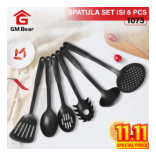

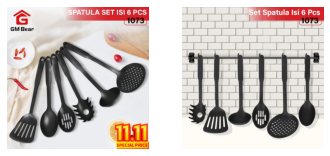

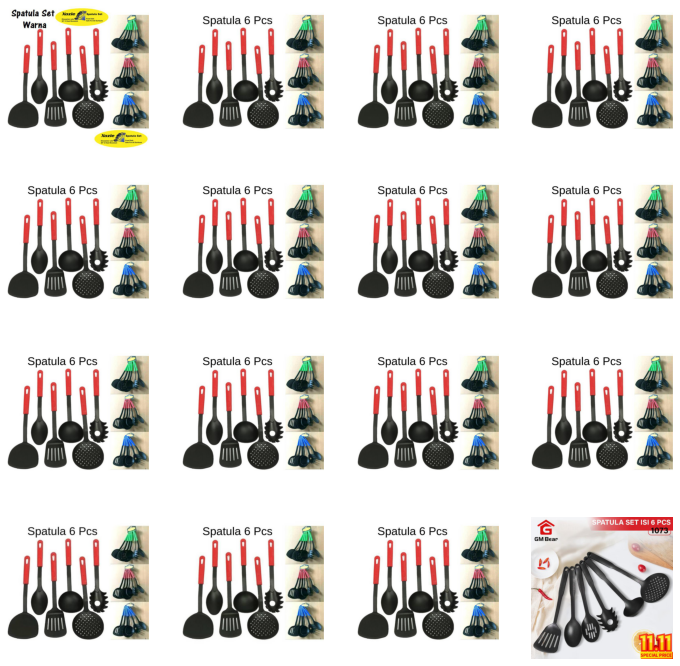

In [28]:
# View products (Set 1)
product = worse_500[0]

get_paths(train_results, product, "product_image")
get_paths(train_results, product, "true_duplicates")
get_paths(train_results, product, "predicted_duplicates");

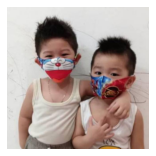

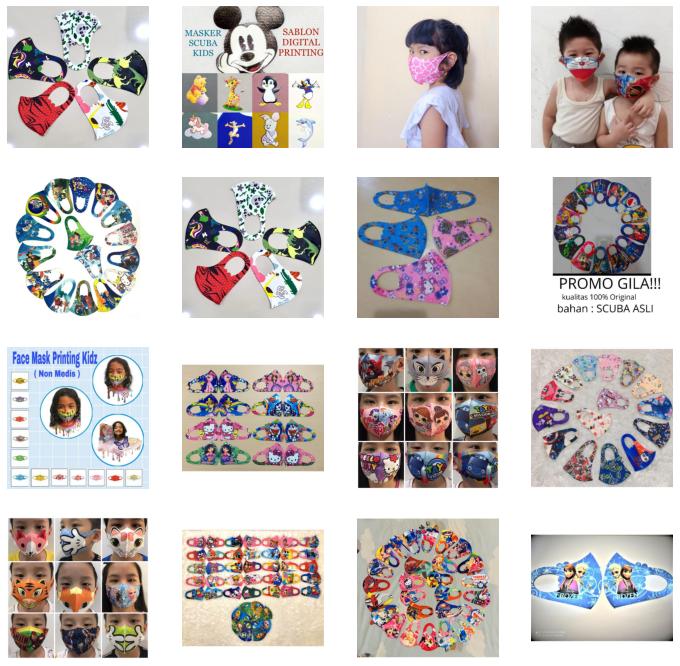

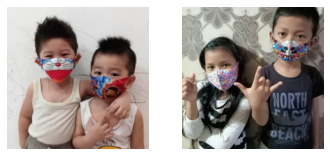

In [27]:
# View products (Set 1)
product = worse_500[9]

get_paths(train_results, product, "product_image")
get_paths(train_results, product, "true_duplicates")
get_paths(train_results, product, "predicted_duplicates");

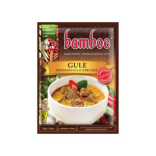

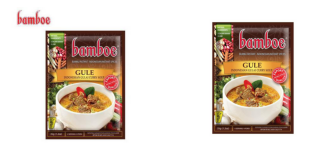

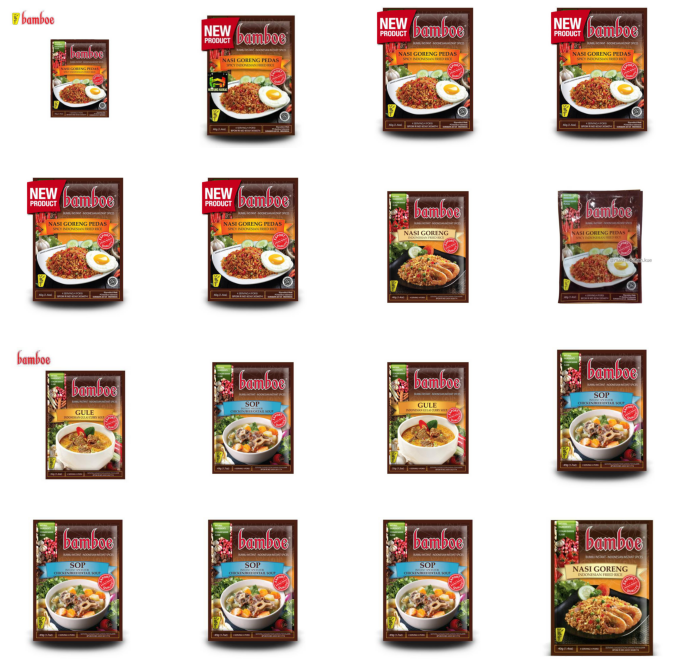

In [662]:
# View products (Set 1)

product = worse_500[170]
get_paths(train_results, product, "product_image")
get_paths(train_results, product, "true_duplicates")
get_paths(train_results, product, "predicted_duplicates");

### Error Analysis notes

Looking at the False Positives and False Negatives, it is clear that the model is able to accurately identify if another product is the same only when the image has a similar shape or form.

For instances of False Positives, it might not be a big issue. In the case of the Kitchenware (Set 1), while the model included non-identical kitchenwares in the predictions, it is clear that such a reccomendation will be helpful for the customer. As they are nonetheless highly similar products which the customer might consider. For the bamboe seasoning packets (Set 3), the model predicted other seasonings but it can be argued that these are still relevant predictions that might be helpful for the customer. As such, we might not consider this to be a very poor prediction.

For instances of False Negatives, it is clear that the model may fall short here. As the model is unable to account for the semantics of the product, it inevitably misses out on similar products that have been presented very differently.

## Conclusions and Reccomendations

The model does well in predicting similar items with a mean F1 score of 0.716 on the train data and 0.724 on the test data. 

We feel that the False Positives can be improved further, but are not detrimental to customer experience as these products are still related to the product of interest. Nonetheless, the model falls short in taking into account the semantics of the product resulting in many false negatives.

Further work can be done to improve predictions by including features which account for these semantics such as product title or product category.

## Plots For presentation Slides
- Use Tsne to reduce dimensionality for plotting

In [32]:
# Extract desired data points

soup = train_results.loc[train_results['posting_id']==worse_500[170],'y_pred'].values[:][0]
c_mask = train_results.loc[train_results['posting_id']==worse_500[9],'y_true'].values[:][0]
a_mask = train_results.loc[train_results['posting_id']==worse_500[40],'y_true'].values[:][0]

In [33]:
#Create new df

train_index = train_results.copy()
train_index.reset_index(inplace=True)

In [35]:
# Extract index of datapoints

soup_index = train_index.loc[train_index['posting_id'].isin(soup),:].index
cmask_index = train_index.loc[train_index['posting_id'].isin(c_mask),:].index
amask_index = train_index.loc[train_index['posting_id'].isin(a_mask),:].index

# Merge indexes into datasets
# Vis dataset 1
all_index = list(soup_index).copy()
all_index.extend(list(cmask_index))
# Vis dataset 2
m_index = list(cmask_index).copy()
m_index.extend(list(amask_index))

In [36]:
# Extract label_groups and posting_ids 

all_labs = train_index.iloc[all_index,:]['label_group']
all_posid = train_index.iloc[all_index,:]['posting_id']

m_labs = train_index.iloc[m_index,:]['label_group']
m_posid = train_index.iloc[m_index,:]['posting_id']

In [37]:
# slice model embeddings with index

all_em = embeddings_train[all_index]

m_em = embeddings_train[m_index]

In [44]:
# Use TSNE to reduce dimensionality to 2

# Plot for child_mask and flavourings
X =  all_em

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
X_embedded.shape

graph_df = pd.DataFrame(X_embedded, columns = ['dim_1', 'dim_2'])
graph_df['labels'] = list(all_labs)
graph_df['posting_id'] = list(all_posid)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

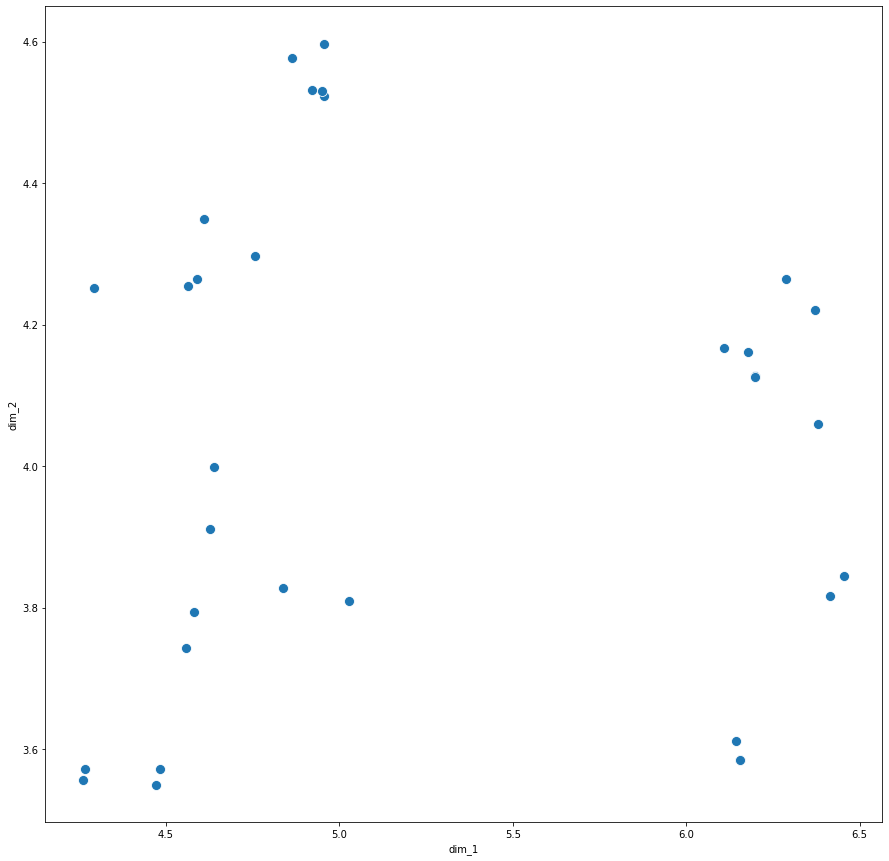

In [46]:
plt.figure(figsize=(15,15))

sns.scatterplot(x = 'dim_1', y = 'dim_2',
                data = graph_df,
#                hue = 'labels',
                palette="deep", legend=False,
                s=100,
#                alpha = 0.5
                )

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

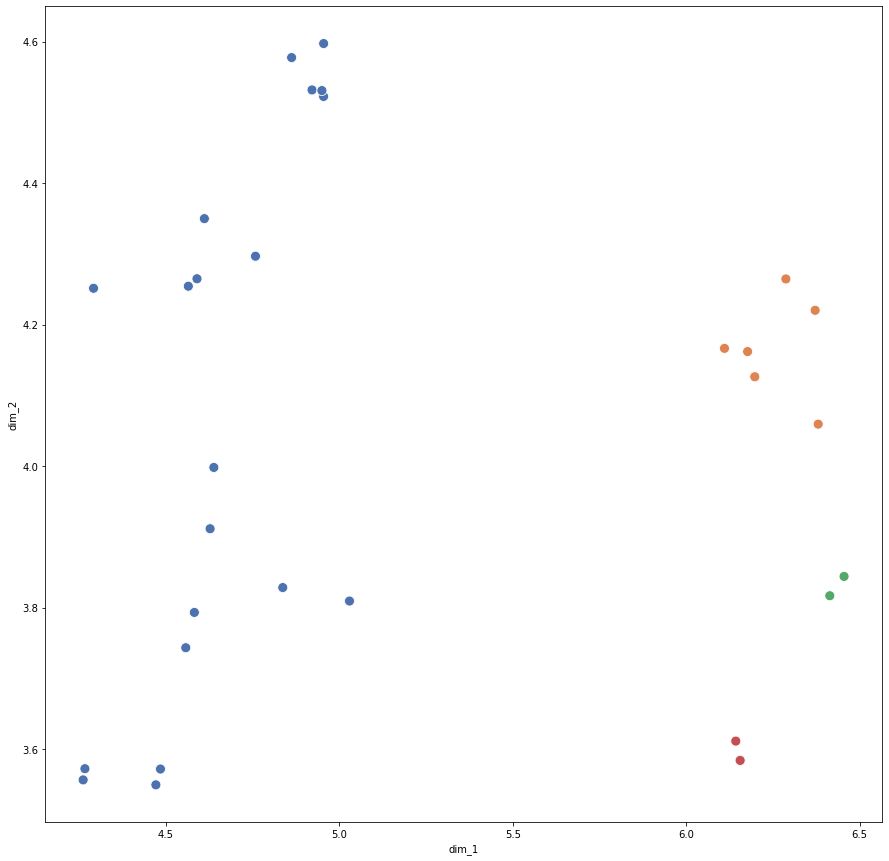

In [45]:
plt.figure(figsize=(15,15))

sns.scatterplot(x = 'dim_1', y = 'dim_2',
                data = graph_df,
                hue = 'labels',
                palette="deep", legend=False,
                s=100,
#                alpha = 0.5
                )

In [655]:
# Use TSNE to reduce dimensionality to 2

# Plot for child_mask and adult_mask
X = m_em

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
X_embedded.shape

graph_df = pd.DataFrame(X_embedded, columns = ['dim_1', 'dim_2'])
graph_df['labels'] = list(m_labs)
graph_df['posting_id'] = list(m_posid)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

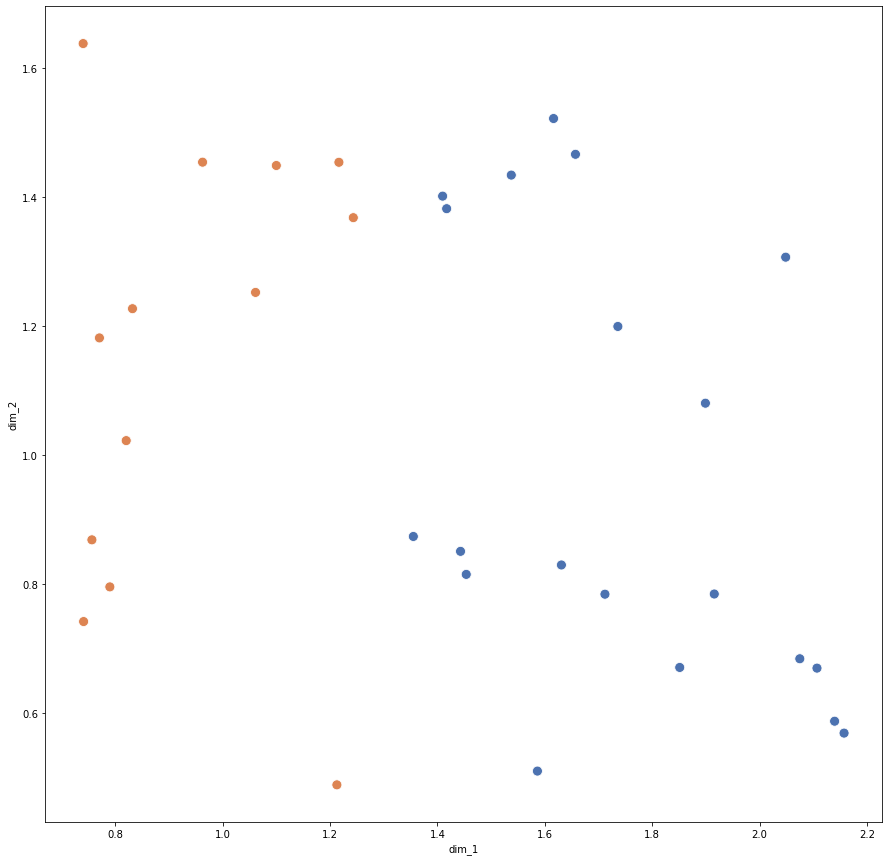

In [656]:
plt.figure(figsize=(15,15))

sns.scatterplot(x = 'dim_1', y = 'dim_2',
                data = graph_df,
                hue = 'labels',
                palette="deep", legend=False,
                s=100,
#                alpha = 0.5
                )